In [35]:
import os

import hydra
from hydra.core.hydra_config import HydraConfig
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf

import torch
import pandas as pd
import plotnine as pn

import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")
sys.path.append("/Users/nathanielimel/uci/projects/ibsg")

from misc.util import get_bound_fn, points_to_df
from misc.tools import normalize_rows
from game.perception import generate_sim_matrix
from analysis.ib import ib_encoder_to_measurements
from game.game import Game

In [36]:
overrides = [
    "game.universe=4", 
    "game.num_signals=2", 
    "game.prior=michael_example_contiguous", 
    "game.discriminative_need_gamma=10", 
    "simulation.dynamics.imprecise_imitation_gamma=10", 
    "game.meaning_dist_gamma=10",
    "game.distance=hamming_dist",
]

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)

# Define a helper which lets us compose new configs since we can't use multirun
def compose(new_overrides):
    """Return a composed hydra config."""
    cfg = hydra.compose(
        config_name="config",
        overrides=overrides + new_overrides,
    )
    return cfg

In [37]:
# Filepaths

# user's path to root of repo
root_path = "/Users/nathanielimel/uci/projects/ibsg"
multirun_path = os.path.join(root_path, config.filepaths.hydra_sweep_root)

#############################################################################
# Analysis files
#############################################################################

curve_dir = os.path.join(multirun_path, config.filepaths.curve_subdir)
curve_fn = get_bound_fn(config, curve_dir=curve_dir)
mse_curve_fn = get_bound_fn(config, "mse", curve_dir=curve_dir)

In [38]:
# load dataframes
read = lambda fn: pd.read_csv(os.path.join(root_path, fn))
curve_data = read(curve_fn)
mse_curve_data = read(mse_curve_fn)

In [39]:
# with prior over states = tensor([0.4000, 0.4000, 0.1000, 0.1000])

# encoders is of shape (num_encoders, meanings, words)
michael_encoders = torch.tensor([
    # encoder 1 is not pareto optimal (?)
    [ 
        [1. , 0.],
        [1. , 0.],
        [0. , 1.],
        [0. , 1.],
    ],
    # encoder 2 is pareto optimal (?),
    [
        [1. , 0.],
        [0. , 1.],
        [1. , 0.],
        [0. , 1.],
    ],
])

In [40]:
# sanity check: add some bad encoders
bad_encoders = torch.tensor([
    # encoder 1
    [ 
        [.25 , .75],
        [.8 , 0.2],
        [.5 , .5],
        [.3 , .7],
    ],
])

# from misc.tools import random_stochastic_matrix
# num = 100
# bad_encoders = torch.stack([ random_stochastic_matrix((4,10)) for _ in range(num) ])

In [41]:
# Measure the complexity and accuracy of these encoders
# use ib measurement function and points to df

# NOTE: use the hydra run dir
cwd = os.path.join("multirun", config.filepaths.simulation_subdir)
cwd = os.path.join(root_path, cwd)
g = Game.from_hydra(config, cwd = cwd)

# NOTE: use the simulation.dynamics.imprecise_imprecision_gamma!
confusion = normalize_rows(generate_sim_matrix(g.universe, 10 ** config.simulation.dynamics.imprecise_imitation_gamma, g.dist_mat))
args = [
    g.meaning_dists,
    g.prior,
    g.dist_mat,
    confusion,
]
encoders_points = [
    ib_encoder_to_measurements(*args, michael_encoders[0]),
    ib_encoder_to_measurements(*args, michael_encoders[1]),
] +  [ib_encoder_to_measurements(*args, bad_encoders[i]) for i in range(len(bad_encoders))]


# some dummy params we need
points_columns = [
    "complexity", 
    "accuracy", 
    "distortion", 
    "mse", 
    ]
efficiency_columns = [
    "gNID", 
    "eps", 
    "beta",
    ]

michael_data = points_to_df(
    points = [
        (
            *points, # comp, acc, dist, mse,
            None, # gNID computed later
            None, # eps (efficiency loss)
            None, # beta
            f"NE_{i+1}", # run number
        )
    for i, points in enumerate(encoders_points[:len(michael_encoders)])
    ] + [
        (
            *points, # comp, acc, dist, mse,
            None, # gNID computed later
            None, # eps (efficiency loss)
            None, # beta
            f"other", # run number
        )
    for i, points in enumerate(encoders_points[len(michael_encoders):])
    ],
    columns = points_columns + efficiency_columns + ["example"],
)

In [42]:
g.prior

tensor([0.4000, 0.4000, 0.1000, 0.1000])

In [43]:
from altk.effcomm.util import bayes
encoder = michael_encoders[0].numpy()
decoder = bayes(michael_encoders[0], g.prior)
pmu = g.meaning_dists.numpy()
pmu @ encoder @ decoder @ pmu

array([[0.5, 0.5, 0. , 0. ],
       [0.5, 0.5, 0. , 0. ],
       [0. , 0. , 0.5, 0.5],
       [0. , 0. , 0.5, 0.5]], dtype=float32)

In [44]:
g.dist_mat.numpy()

array([[0., 1., 1., 1.],
       [1., 0., 1., 1.],
       [1., 1., 0., 1.],
       [1., 1., 1., 0.]], dtype=float32)

In [45]:
# Let's confirm the EU
import numpy as np
np.sum(np.diag(g.prior) @ pmu @ encoder @ decoder @ pmu * g.utility.numpy())

0.5

In [46]:
# Let's try and figure out why NE1 has higher accuracy

# compute the mse
from altk.effcomm.information import expected_distortion
from altk.effcomm.util import bayes

pmu = g.meaning_dists.numpy()
dist_mat = g.dist_mat.numpy()
utility = g.utility.numpy()
prior = g.prior.numpy()

# BUG: hard code prior for now, then add to csv
# prior = np.array([.4, .1, .4, .1])
prior = np.array([.4, .4, .1, .1])

print("prior: ")
print(prior)
print()
print("meaning dists: ")
print(pmu)
print()
print("dist_mat: ")
print(dist_mat)
print()
print("utility: ")
print(utility)
print()

for i in range(len(michael_encoders)):
    print(f"NE_{i+1}")
    encoder = michael_encoders[i].numpy()
    transpose_decoder = encoder.T / encoder.T.sum(axis=1, keepdims=True)
    bayesian_decoder = bayes(encoder, prior) # numpy

    michael_decoder = np.array([[1., 0., 0., 0.,],[0., 0., 1., 0.]])

    system = pmu @ encoder @ bayesian_decoder @ pmu
    eu = np.sum(np.diag(prior) @ system * utility)
    dist = expected_distortion(prior, system, dist_mat)

    system_t = pmu @ encoder @ transpose_decoder @ pmu
    eu_t = np.sum(prior @ system_t * utility)
    dist_t = expected_distortion(prior, system_t, dist_mat)

    system_m = pmu @ encoder @ michael_decoder @ pmu
    eu_m = np.sum(np.diag(prior) @ system_m * utility)
    dist_m = expected_distortion(prior, system, dist_mat)

    print("-----------------------")
    print("Encoder: ")
    print(encoder)
    print()
    print("Bayesian Decoder: ")
    print(bayesian_decoder)
    print()
    print("Transpose Decoder: ")
    print(transpose_decoder)
    print()
    print("System: ")
    print(system)
    print()
    print("Expected Utility: bayesian:")
    print(eu)
    print()
    print("Expected Distortion: bayesian")
    print(dist)
    print()
    print("Expected Utility: transpose:")
    print(eu_t)
    print()
    print("Expected Distortion: transpose")
    print(dist_t)
    print()
    print("Expected Utility: Michael")
    print(eu_m)
    print("dist:", dist_m)
    print()

prior: 
[0.4 0.4 0.1 0.1]

meaning dists: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

dist_mat: 
[[0. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]]

utility: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

NE_1
-----------------------
Encoder: 
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]

Bayesian Decoder: 
[[0.5 0.5 0.  0. ]
 [0.  0.  0.5 0.5]]

Transpose Decoder: 
[[0.5 0.5 0.  0. ]
 [0.  0.  0.5 0.5]]

System: 
[[0.5 0.5 0.  0. ]
 [0.5 0.5 0.  0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.5 0.5]]

Expected Utility: bayesian:
0.5

Expected Distortion: bayesian
0.5

Expected Utility: transpose:
1.0

Expected Distortion: transpose
0.5

Expected Utility: Michael
0.5
dist: 0.5

NE_2
-----------------------
Encoder: 
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]

Bayesian Decoder: 
[[0.8 0.  0.2 0. ]
 [0.  0.8 0.  0.2]]

Transpose Decoder: 
[[0.5 0.  0.5 0. ]
 [0.  0.5 0.  0.5]]

System: 
[[0.8 0.  0.2 0. ]
 [0.  0.8 0.  0.2]
 [0.8 0.  0.2 0. ]
 [0.  0.8 0.  0.2]]

Expec

In [47]:
michael_data

,complexity,accuracy,distortion,mse,gNID,eps,beta,example
0,0.721928,0.721928,1.000000,0.5000,None,None,None,NE_1
1,1.000000,1.000000,0.721928,0.3200,None,None,None,NE_2
2,0.198588,0.198588,1.523340,0.5608,None,None,None,other


In [48]:
curve_data = curve_data[curve_data["complexity"] > 0]
curve_data

,complexity,accuracy,distortion
11,8.450489e-10,8.450494e-10,1.721928e+00
12,4.988428e-09,4.988428e-09,1.721928e+00
13,2.186843e-08,2.186843e-08,1.721928e+00
14,2.378111e-08,2.378111e-08,1.721928e+00
15,5.125142e-08,5.125142e-08,1.721928e+00
...,...,...,...
166,1.721928e+00,1.721928e+00,-2.178073e-07
167,1.721928e+00,1.721928e+00,-2.178074e-07
168,1.721928e+00,1.721928e+00,-2.178074e-07
169,1.721928e+00,1.721928e+00,-2.178074e-07


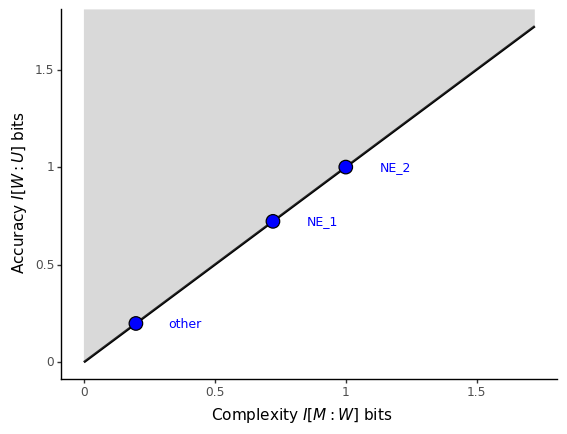

In [49]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # testing langs
        data=michael_data,
        fill="blue",
        size=5,
    )
    + pn.geom_text(
        michael_data,
        pn.aes(label="example"),
        color="blue",
        ha="right",
        size=9,  # orig 9
        nudge_x=.25,
    )
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Accuracy $I[W:U]$ bits")
    + pn.theme_classic()
)
print(plot)

In [50]:
mse_curve_data = mse_curve_data[mse_curve_data["complexity"] > 0]
mse_curve_data

,complexity,mse
2,4.768372e-07,0.741847
3,4.768372e-07,0.737777
4,1.430511e-06,0.733719
5,2.384186e-06,0.729678
6,3.576279e-06,0.725659
...,...,...
995,1.721928e+00,0.000000
996,1.721928e+00,0.000000
997,1.721928e+00,0.000000
998,1.721928e+00,0.000000


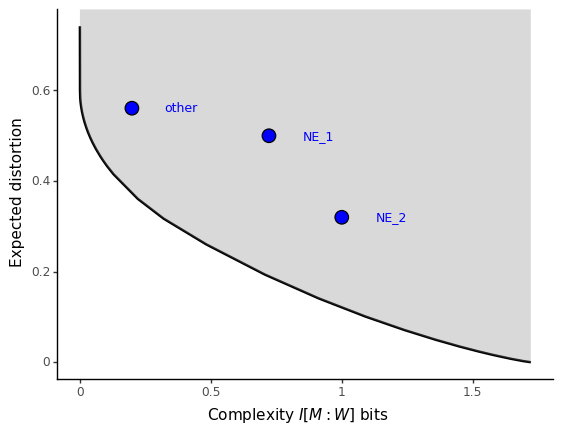

In [51]:

plot = (
    # Set data and the axes
    pn.ggplot(
        data=mse_curve_data, mapping=pn.aes(x="complexity", y="mse")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="mse",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # testing langs
        data=michael_data,
        size=5,
        fill="blue",
    )
    + pn.geom_text(
        michael_data,
        pn.aes(label="example"),
        ha="right",
        size=9,  # orig 9
        nudge_x=.25,
        color="blue",
    )
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Expected distortion")
    + pn.theme_classic()
)
print(plot)

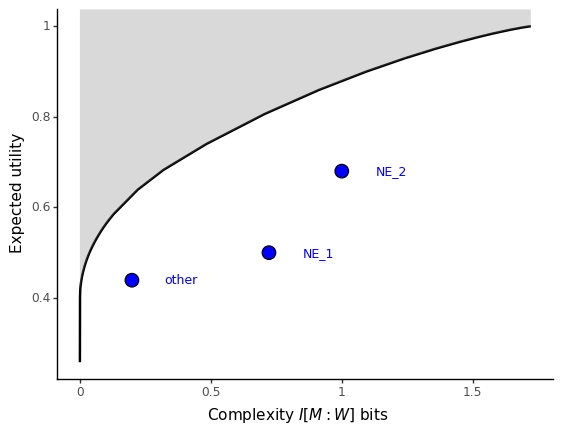

In [52]:
# For ease of comparison, perhaps use a complexity/utility bound, which is just 1 - the hamming distortion.

michael_data["eu"] = 1 - michael_data["mse"]
mse_curve_data["eu"] = 1 - mse_curve_data["mse"]


plot = (
    # Set data and the axes
    pn.ggplot(
        data=mse_curve_data, mapping=pn.aes(x="complexity", y="eu")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="eu",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # testing langs
        data=michael_data,
        size=5,
        fill="blue",
    )
    + pn.geom_text(
        michael_data,
        pn.aes(label="example"),
        ha="right",
        size=9,  # orig 9
        nudge_x=.25,
        color="blue",
    )
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Expected utility")
    + pn.theme_classic()
)
print(plot)

In [53]:
# Lets check if the negative EU can serve as a distortion measure

## New equilibrium examples

Four states, all equally probable, two messages, Lewis-game payoffs.

In [ ]:
# Equilibrium 1
# s1 | s2 | s3 -> m1 -> s1
# s4 -> m2 -> s4

sender_matrix = torch.tensor(
    [
        [1., 0.,],
        [1., 0.,],
        [1., 0.,],
        [0., 1.,],
    ]
)
receiver_matrix = torch.tensor(
    [
        [1., 0., 0., 0.,],
        [0., 0., 0., 1.],
    ]
)

ib_encoder_to_measurements(
    g.meaning_dists,
    g.prior,
    g.dist_mat,
    confusion,
    encoder = sender_matrix,
    decoder = receiver_matrix,
)